In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipykernel import kernelapp as app
%matplotlib inline

In [2]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

## MNISTデータセット

In [3]:
import keras
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


## データセットの確認

In [4]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

## 平滑化

In [5]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

## 画像データの可視化

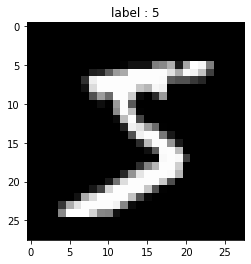

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray', vmin = 0, vmax = 255)
plt.title('label : {}'.format(y_train[index]))
plt.show()

## 前処理

In [7]:
# 0から1のfloat型に変換
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [8]:
# one-hot表現 に変換
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [9]:
# 訓練データと検証データに分割
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


# 【問題1】全結合層のクラス化

全結合層のクラス化を行なってください。  
以下に雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。  
なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。  
また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。  
初期化方法と最適化手法のクラスについては後述します。

In [10]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, act_func):
        
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes1, n_nodes2)
        self.act_func = act_func
        
        self.X = None
        self.dW = None
        self.dB = None
        self.hW = 1
        self.hB = 1
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """      
        self.X = X
        A = X @ self.W + self.B
        
        return A
    
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dZ = dA @ self.W.T
        self.dB = np.sum(dA, axis=0, keepdims=True)
        self.dW = self.X.T @ dA
        
         # 更新
        self = self.optimizer.update(self)
        return dZ

# 【問題2】初期化方法のクラス化

初期化を行うコードをクラス化してください。  
前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。以下の雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。  
これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。

In [11]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma

    
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    
    def B(self, n_nodes1, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

# 【問題3】最適化手法のクラス化

最適化手法のクラス化を行なってください。  
最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself.optimizer.update(self)のように更新できるようにします。以下の雛形に必要なコードを書き加えていってください。  
これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

In [12]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W = layer.W - self.lr  * layer.dW
        layer.B = layer.B - self.lr  * layer.dB
        
        return layer

# 【問題4】活性化関数のクラス化

活性化関数のクラス化を行なってください。
ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。

In [13]:
class Sigmoid:
    
    def __init__(self):
        self.Z = None
        
    def forward(self, A):
        self.Z = self.sigmoid(A)
        return self.Z
        
    def backward(self, dZ):
        dA = dZ * (1.0 - self.sigmoid(self.Z)) * self.sigmoid(self.Z)
        return dA
    
    def sigmoid(self, X):
        return 1.0 / (1.0 + np.exp(-X))

In [14]:
class Tanh:
    
    def __init__(self):
        self.Z = None
        
    def forward(self, A):
        self.Z = np.tanh(A)
        return self.Z
        
    def backward(self, dZ):
        dA = dZ * (1. - np.tanh(self.Z)**2)  
        return dA

In [15]:
class Softmax:
    
    def __init__(self):
        self.Z = None
    
    def forward(self, A):
        self.Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
        return self.Z
        
    def backward(self, dZ):
        dA = dZ
        return dA   

#### 発展的要素
活性化関数や重みの初期値、最適化手法に関してこれまで見てきた以外のものを実装していきます。

# 【問題5】ReLUクラスの作成

現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装してください。  
ReLUは以下の数式です。  
## $$
% <![CDATA[
f(x) = ReLU(x) = \begin{cases}
x  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$$
$x$ : ある特徴量。スカラー  
実装上はnp.maximumを使い配列に対してまとめて計算が可能です。  
numpy.maximum — NumPy v1.15 Manual  
一方、バックプロパゲーションのための x に関する f(x) の微分は以下のようになります。  
## $$
% <![CDATA[
\frac{\partial f(x)}{\partial x} = \begin{cases}
1  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$$
数学的には微分可能ではないですが、 x=0 のとき 0 とすることで対応しています。  
フォワード時の x の正負により、勾配を逆伝播するかどうかが決まるということになります。

In [16]:
class ReLU:
    
    def __init__(self):
        self.index = None
        
    def forward(self, A):
        self.index = A < 0
        Z = A.copy()
        Z[self.index] = 0
        return Z
        
    def backward(self, dZ):
        dZ[index] = 0
        dA = dZ
        return dA

# 【問題6】重みの初期値

ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、どのような値にすると良いかが知られています。シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。  
XavierInitializerクラスと、HeInitializerクラスを作成してください。  
#### Xavierの初期値  
Xavierの初期値における標準偏差 $\sigma$ は次の式で求められます。  
## $$
\sigma = \frac{1}{\sqrt{n}}
$$
$n$ : 前の層のノード数

In [17]:
class XavierInitializer:
    
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = (1 / np.sqrt(n_nodes1)) * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    
    def B(self, n_nodes1, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = (1 / np.sqrt(n_nodes1)) * np.random.randn(1, n_nodes2)    
        return B

#### Heの初期値
Heの初期値における標準偏差 $\sigma$ は次の式で求められます。
## $$
\sigma = \sqrt{\frac{2}{n}}
$$
$n$ : 前の層のノード数

In [18]:
class HeInitializer:
    
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = np.sqrt(2 / n_nodes1) * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    
    def B(self, n_nodes1, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.sqrt(2 / n_nodes1) * np.random.randn(1, n_nodes2)        
        return B     

# 【問題7】最適化手法

学習率は学習過程で変化させていく方法が一般的です。基本的な手法である AdaGrad のクラスを作成してください。  
まず、これまで使ってきたSGDを確認します。  
## $$
W_i^{\prime} = W_i - \alpha E(\frac{\partial L}{\partial W_i}) \\
$$
## $$
B_i^{\prime} = B_i - \alpha E(\frac{\partial L}{\partial B_i})
$$
$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）  
$\frac{\partial L}{\partial W_i}$ : $W_i$ に関する損失 L の勾配  
$\frac{\partial L}{\partial B_i}$ : $B_i$ に関する損失 L の勾配  
$E()$ : ミニバッチ方向にベクトルの平均を計算  
続いて、AdaGradです。バイアスの数式は省略しますが、重みと同様のことをします。  
更新された分だけその重みに対する学習率を徐々に下げていきます。イテレーションごとの勾配の二乗和 H を保存しておき、その分だけ学習率を小さくします。  
学習率は重み一つひとつに対して異なることになります。  
## $$
H_i^{\prime}  = H_i+E(\frac{\partial L}{\partial W_i})×E(\frac{\partial L}{\partial W_i})\\
$$
## $$
W_i^{\prime} = W_i - \alpha \frac{1}{\sqrt{H_i^{\prime} }} E(\frac{\partial L}{\partial W_i}) \\
$$
$H_i$ : i層目に関して、前のイテレーションまでの勾配の二乗和（初期値は0）  
$H_i^{\prime}$ : 更新した $H_i$

In [19]:
class AdaGrad:
    
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        
        layer.hB = layer.hB + layer.dB * layer.dB
        layer.hW = layer.hW + layer.dW * layer.dW
        
        layer.B = layer.B - self.lr * (layer.dB/np.sqrt(layer.hB)+1e-7)
        layer.W = layer.W - self.lr * (layer.dW/np.sqrt(layer.hW)+1e-7)
        
        return layer

# 【問題8】クラスの完成

任意の構成で学習と推定が行えるScratchDeepNeuralNetrowkClassifierクラスを完成させてください。

In [20]:
class ScratchDeepNeuralNetrowkClassifier:
    
    def __init__(self, epoch, batch_size, lr, optimizer='SGD', sigma=0.1):
        self.epoch = epoch                       # エポック数
        self.batch_size = batch_size      # バッチ数
        self.lr = lr                                        # 学習率
        self.optimizer = optimizer            # 勾配法
        self.sigma = sigma                        # シグマ（初期化用）
        
        self.layers = []                               # レイヤーの配列を初期化
        self.loss = []                                   # loss（エポックごと）の配列を初期化
        
    def add(self, n_nodes1, n_nodes2, activation):
        
        # 選択した活性化関数により「イニシャライザ」と「活性化関数」のオブジェクトを作成
        if activation == 'relu':
            initializer = HeInitializer()
            act_func = ReLU()
        elif activation == 'sigmoid':
            initializer = XavierInitializer()
            act_func = Sigmoid()
        elif activation == 'tanh':
            initializer = XavierInitializer()
            act_func = Tanh()
        elif activation == 'softmax':
            initializer = SimpleInitializer(self.sigma)
            act_func = Softmax()  
        
        # 選択した勾配法により「勾配法」のオブジェクトを作成
        if self.optimizer == 'SGD':
            optimizer = SGD(self.lr)
        elif self.optimizer == 'AdaGrad':
            optimizer = AdaGrad(self.lr)
            
        self.layers.append(FC(n_nodes1, n_nodes2, initializer, optimizer, act_func))
        
        
    def fit(self, X, y):
        
        for e in np.arange(self.epoch):
            
            loss_buf = [] # loss（バッチサイズごと）の配列を初期化
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size) # ミニバッチに分割
            
            for mini_X_train, mini_y_train in get_mini_batch:
                
                # ★★★★ フォワードプロパゲーション ★★★★
                Z = mini_X_train # 初期値を代入
                
                for layer in self.layers:
                    A = layer.forward(Z)
                    Z = layer.act_func.forward(A)
                    
                    
                # ★★★★ 交差エントロピー誤差（バッチサイズごと） ★★★★                
                loss_buf.append(self.cross_entropy_error(Z,  mini_y_train))                    
                    
                    
                #  ★★★★ バックプロパゲーション ★★★★
                dZ = Z - mini_y_train
                
                for layer in self.layers[::-1]:
                    dA = layer.act_func.backward(dZ)
                    dZ = layer.backward(dA)
                    
            # ★★★★ 交差エントロピー誤差（エポックごと） ★★★★                
            self.loss.append(np.mean(loss_buf))                          
                    
             
    def predict(self, X):
    
        Z = X # 初期値を代入
        
        for layer in self.layers:
            A = layer.forward(Z)
            Z = layer.act_func.forward(A)    
            
        y_pred = np.argmax(Z,axis=1)     
    
        return y_pred
    
    def cross_entropy_error(self, y_pred,  y_true):
        delta = 1e-7
        return -np.sum(y_true * np.log(y_pred + delta)) / self.batch_size    

# 【問題9】学習と推定

層の数や活性化関数を変えたいくつかのネットワークを作成してください。そして、MNISTのデータを学習・推定し、Accuracyを計算してください。

In [21]:
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.fit_transform(y_val[:, np.newaxis])
print(X_train.shape)
print(y_train_one_hot.shape)

(48000, 784)
(48000, 10)


## ① 中間層数：２ ・・・前回と同じ条件

In [22]:
clf = ScratchDeepNeuralNetrowkClassifier(epoch=5, batch_size=20, lr=0.01, optimizer='SGD', sigma=0.1)
clf.add(n_nodes1=784, n_nodes2=400, activation = 'sigmoid')
clf.add(n_nodes1=400, n_nodes2=200, activation = 'relu')
clf.add(n_nodes1=200, n_nodes2=10, activation = 'softmax')

In [23]:
clf.fit(X_train, y_train_one_hot)

In [24]:
y_pred = clf.predict(X_val)

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred)

0.9235833333333333

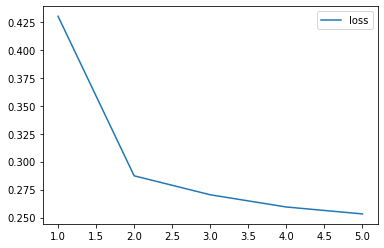

In [26]:
plt.plot(range(1,6), clf.loss, label='loss')
plt.legend()

## ② 中間層数：2 ・・・「AdaGrad」を仕様した場合

In [27]:
clf = ScratchDeepNeuralNetrowkClassifier(epoch=5, batch_size=20, lr=0.01, optimizer='AdaGrad', sigma=0.1)
clf.add(n_nodes1=784, n_nodes2=400, activation = 'sigmoid')
clf.add(n_nodes1=400, n_nodes2=200, activation = 'relu')
clf.add(n_nodes1=200, n_nodes2=10, activation = 'softmax')

In [28]:
clf.fit(X_train, y_train_one_hot)

In [29]:
y_pred = clf.predict(X_val)

In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred)

0.9289166666666666

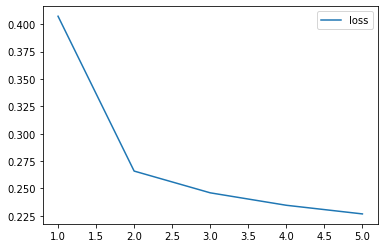

In [31]:
plt.plot(range(1,6), clf.loss, label='loss')
plt.legend()

## ③ 中間層数：3 ・・・中間層を増やした場合

In [32]:
clf = ScratchDeepNeuralNetrowkClassifier(epoch=5, batch_size=20, lr=0.01, optimizer='AdaGrad', sigma=0.1)
clf.add(n_nodes1=784, n_nodes2=400, activation = 'tanh')
clf.add(n_nodes1=400, n_nodes2=800, activation = 'sigmoid')
clf.add(n_nodes1=800, n_nodes2=200, activation = 'sigmoid')
clf.add(n_nodes1=200, n_nodes2=10, activation = 'softmax')

In [33]:
clf.fit(X_train, y_train_one_hot)

In [34]:
y_pred = clf.predict(X_val)

In [35]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred)

0.9459166666666666

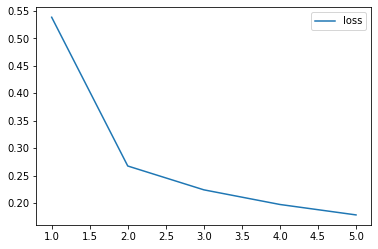

In [36]:
plt.plot(range(1,6), clf.loss, label='loss')
plt.legend()

## ④ 中間層数：3 ・・・中間層のノード数を増やした場合

In [37]:
clf = ScratchDeepNeuralNetrowkClassifier(epoch=5, batch_size=20, lr=0.01, optimizer='AdaGrad', sigma=0.1)
clf.add(n_nodes1=784, n_nodes2=800, activation = 'tanh')
clf.add(n_nodes1=800, n_nodes2=800, activation = 'sigmoid')
clf.add(n_nodes1=800, n_nodes2=200, activation = 'sigmoid')
clf.add(n_nodes1=200, n_nodes2=10, activation = 'softmax')

In [38]:
clf.fit(X_train, y_train_one_hot)

In [39]:
y_pred = clf.predict(X_val)

In [40]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred)

0.9508333333333333

In [41]:
clf.loss

[0.5047238626532675,
 0.24700585127697924,
 0.20288107743474787,
 0.17626830256488862,
 0.15731428457873972]

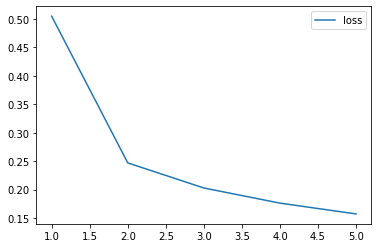

In [42]:
plt.plot(range(1,6), clf.loss, label='loss')
plt.legend()

## 考察
### 中間層の数や中間層のノード数を増やしても必ずしもAccuracyが上がるわけではない。
### 「SGD」より「AdaGrad」の方が最適な学習率で学習される傾向にある。